In [2]:
import os
import glob
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler
# Fix random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# ---------------------- Hyperparameters ---------------------- #
SAMPLE_RATE = 16000   # Audio sample rate
AUDIO_LEN   = 16000   # 1-second audio (16k samples)
BATCH_SIZE  = 256      # Batch size for training
LR          = 1e-3    # Learning rate

HIDDEN_DIM  = 32      # Hidden dimension for LSTM in Generator
CHANNELS    = 32      # Initial convolution channels
OUTPUT_CH   = 128     # Final conv channels for Generator
STRIDES     = [2, 4, 5, 8]  # Downsampling strides
LSTM_LAYERS = 2       # Number of LSTM layers
NUM_WORKERS = 16       # DataLoader workers

# Loss Weights for this Phase 1 (Generator-only)
lambda_L1     = 1.0
lambda_msspec = 1.0
lambda_loud   = 0.5
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision('high')
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
class OneSecClipsDataset(Dataset):
    """
    Assumes each .wav file in root_dir is a ~1-sec clip (16k samples).
    If sample_rate != 16000, it resamples to 16k.
    """
    def __init__(self, root_dir, sample_rate=SAMPLE_RATE):
        super().__init__()
        self.filepaths = glob.glob(os.path.join(root_dir, '**', '*.wav'), recursive=True)
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        wav_path = self.filepaths[idx]
        waveform, sr = torchaudio.load(wav_path)

        # Convert to mono if multi-channel
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)

        # Ensure the clip is 1 second (pad/crop if necessary)
        if waveform.shape[1] > AUDIO_LEN:
            waveform = waveform[:, :AUDIO_LEN]
        elif waveform.shape[1] < AUDIO_LEN:
            pad_amt = AUDIO_LEN - waveform.shape[1]
            waveform = F.pad(waveform, (0, pad_amt))

        return waveform  # shape: (1, AUDIO_LEN)

def watermark_masking_augmentation(wav, p_replace_orig=0.4, p_replace_zero=0.2, p_replace_diff=0.2):
    """
    Randomly masks portions of the audio:
    - p_replace_orig: do nothing
    - p_replace_zero: replace segment with zeros
    - p_replace_diff: replace segment with random noise
    """
    T = wav.shape[1]
    window_len = int(0.1 * SAMPLE_RATE)
    k = 5
    for _ in range(k):
        start = random.randint(0, T - window_len)
        end = start + window_len
        choice = random.random()
        if choice < p_replace_orig:
            pass
        elif choice < p_replace_orig + p_replace_zero:
            wav[:, start:end] = 0.0
        elif choice < p_replace_orig + p_replace_zero + p_replace_diff:
            wav[:, start:end] = 0.1 * torch.randn_like(wav[:, start:end])
        else:
            pass
    return wav

def robustness_augmentations(wav):
    """
    Adds small random noise for robustness.
    """
    return wav + 0.005 * torch.randn_like(wav)


In [4]:
def make_conv1d(in_ch, out_ch, kernel_size=3, stride=1, padding=1):
    return nn.Conv1d(in_ch, out_ch, kernel_size, stride=stride, padding=padding)

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.downsample = (stride != 1 or in_ch != out_ch)
        self.conv1 = make_conv1d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.conv2 = make_conv1d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.elu   = nn.ELU()
        if self.downsample:
            self.skip_conv = make_conv1d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0)

    def forward(self, x):
        residual = x
        out = self.elu(self.conv1(x))
        out = self.conv2(out)
        if self.downsample:
            residual = self.skip_conv(residual)
        out = self.elu(out + residual)
        return out

class Generator(nn.Module):
    def __init__(self, 
                 in_channels=1, 
                 base_channels=CHANNELS,
                 hidden_dim=HIDDEN_DIM, 
                 output_channels=OUTPUT_CH, 
                 strides=STRIDES):
        super().__init__()
        
        # ---------- Encoder ----------
        self.init_conv = nn.Conv1d(in_channels, base_channels, kernel_size=7, stride=1, padding=3)
        
        enc_blocks = []
        ch = base_channels
        for st in strides:
            out_ch = ch * 2
            enc_blocks.append(ResidualBlock(ch, out_ch, stride=st))
            ch = out_ch
        self.encoder_blocks = nn.Sequential(*enc_blocks)

        # Project encoder output to hidden_dim (for LSTM)
        self.proj = nn.Linear(ch, hidden_dim)

        # LSTM
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, 
                            num_layers=LSTM_LAYERS, batch_first=True, bidirectional=False)

        self.final_conv_enc = nn.Conv1d(hidden_dim, output_channels, kernel_size=7, stride=1, padding=3)

        # ---------- Decoder ----------
        dec_blocks = []
        rev_strides = list(reversed(strides))
        in_ch = output_channels
        for st in rev_strides:
            out_ch = in_ch // 2
            dec_blocks.append(nn.ConvTranspose1d(in_ch, out_ch, kernel_size=2*st, stride=st,
                                                 padding=(st//2), output_padding=0))
            dec_blocks.append(ResidualBlock(out_ch, out_ch, stride=1))
            in_ch = out_ch
        self.decoder_blocks = nn.Sequential(*dec_blocks)

        # Final conv -> 1 channel for the delta
        self.final_conv_dec = nn.Conv1d(in_ch, 1, kernel_size=7, stride=1, padding=3)

    def forward(self, s):
        """
        s: shape (B, 1, T)
        Output: delta (B, 1, T)
        """
        B, _, T = s.shape

        # Encode
        x = self.init_conv(s)
        x = self.encoder_blocks(x)  
        x_t = x.transpose(1, 2)     # (B, T_enc, ch)
        x_t = self.proj(x_t)        # (B, T_enc, hidden_dim)

        # LSTM
        lstm_out, _ = self.lstm(x_t)           # (B, T_enc, hidden_dim)
        lstm_out_t = lstm_out.transpose(1, 2)  # (B, hidden_dim, T_enc)
        latent = self.final_conv_enc(lstm_out_t)

        # Decode
        x_dec = self.decoder_blocks(latent)
        delta = self.final_conv_dec(x_dec)

        # Adjust shape if needed
        if delta.shape[-1] != T:
            min_len = min(delta.shape[-1], T)
            delta = delta[:, :, :min_len]
            if min_len < T:
                pad_amt = T - min_len
                delta = F.pad(delta, (0, pad_amt))

        return delta


In [5]:
import torchaudio.transforms as T

class SimpleMelLoss(nn.Module):
    def __init__(self, sample_rate=SAMPLE_RATE, n_fft=1024, n_mels=80):
        super(SimpleMelLoss, self).__init__()
        self.mel_spec = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=n_fft // 4,
            n_mels=n_mels,
            normalized=True
        )
        
    def forward(self, original, watermarked):
        mel_orig = torch.log(self.mel_spec(original) + 1e-5)
        mel_wm   = torch.log(self.mel_spec(watermarked) + 1e-5)
        return F.l1_loss(mel_orig, mel_wm)

class TFLoudnessLoss(nn.Module):
    def __init__(self, n_bands=8, window_size=2048, hop_size=512):
        super(TFLoudnessLoss, self).__init__()
        self.n_bands = n_bands
        self.win_size = window_size
        self.hop_size = hop_size
        
        weights = torch.ones(n_bands)
        mid_band_idx = n_bands // 3
        weights[mid_band_idx:2 * mid_band_idx] = 1.5
        self.register_buffer('band_weights', weights)

    def forward(self, original, watermarked):
        window = torch.hann_window(self.win_size, device=original.device)
        stft_orig = torch.stft(
            original.squeeze(1), n_fft=self.win_size, hop_length=self.hop_size,
            window=window, return_complex=True, normalized=True
        )
        stft_wm = torch.stft(
            watermarked.squeeze(1), n_fft=self.win_size, hop_length=self.hop_size,
            window=window, return_complex=True, normalized=True
        )
        mag_orig = stft_orig.abs()
        mag_wm   = stft_wm.abs()
        phase_orig = stft_orig.angle()
        phase_wm   = stft_wm.angle()
        
        freq_bins = mag_orig.shape[1]
        band_size = freq_bins // self.n_bands
        
        loudness_loss = 0.0
        spectral_loss = 0.0
        phase_loss = 0.0
        
        for b in range(self.n_bands):
            start = b * band_size
            end = freq_bins if (b == self.n_bands - 1) else (start + band_size)
            band_orig = mag_orig[:, start:end, :]
            band_wm = mag_wm[:, start:end, :]
            
            energy_orig = torch.sum(band_orig ** 2, dim=1)
            energy_wm = torch.sum(band_wm ** 2, dim=1)
            loud_orig = torch.log10(energy_orig + 1e-8)
            loud_wm   = torch.log10(energy_wm + 1e-8)
            loudness_loss += self.band_weights[b] * F.l1_loss(loud_wm, loud_orig)
            spectral_loss += self.band_weights[b] * F.mse_loss(band_wm, band_orig)
            phase_diff = 1.0 - torch.cos(phase_wm[:, start:end, :] - phase_orig[:, start:end, :])
            phase_loss += self.band_weights[b] * phase_diff.mean()
        
        loudness_loss /= self.n_bands
        spectral_loss /= self.n_bands
        phase_loss /= self.n_bands
        
        return loudness_loss + spectral_loss + 0.2 * phase_loss


In [6]:
def train_generator(
    generator,
    train_ds,
    val_ds,
    device,
    num_epochs=10,
    lr=1e-3,
    lambda_L1=1.0,
    lambda_msspec=1.0,
    lambda_loud=0.5,
    use_robustness=False
):
    """
    Trains only the Generator (no adversarial or detector), 
    with a separate validation set. 
    Prints sub-losses for each batch in train, 
    and average sub-losses in validation each epoch.

    Args:
        generator: (nn.Module) The generator model
        train_ds: training dataset
        val_ds: validation dataset
        device: 'cpu' or 'cuda'
        num_epochs: int
        lr: float, learning rate
        lambda_L1, lambda_msspec, lambda_loud: weighting factors
        use_robustness: bool, whether to apply segment masking/noise in training
    """
    # Create DataLoaders
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,pin_memory=True)

    optimizer = optim.Adam(generator.parameters(), lr=lr)
    generator.train()

    ms_mel_loss_fn = SimpleMelLoss().to(device)
    tf_loud_loss_fn = TFLoudnessLoss().to(device)
    
    scaler = torch.amp.GradScaler('cuda')
    

    for epoch in range(1, num_epochs+1):
        # ------------------- TRAINING LOOP ------------------- #
        generator.train()
        train_pbar = tqdm(train_loader, desc=f"[Epoch {epoch}/{num_epochs} - Train]", leave=True)
        
        running_l1, running_mel, running_loud, running_total = 0.0, 0.0, 0.0, 0.0
        num_batches = len(train_loader)

        for batch_data in train_pbar:
            s = batch_data.to(device)  # (B,1,T)
            optimizer.zero_grad()            
            with torch.amp.autocast('cuda'):
                # Forward pass
                delta = generator(s)
                s_w = s + delta

                if use_robustness:
                    for i in range(s_w.shape[0]):
                        s_w[i] = watermark_masking_augmentation(s_w[i])
                        s_w[i] = robustness_augmentations(s_w[i])

                loss_l1 = F.l1_loss(delta, torch.zeros_like(delta))
                loss_mel = ms_mel_loss_fn(s, s_w)
                loss_loud = tf_loud_loss_fn(s, s_w)

                loss_total = (lambda_L1 * loss_l1 +
                              lambda_msspec * loss_mel +
                              lambda_loud * loss_loud)

            # Scale loss and backpropagate
            scaler.scale(loss_total).backward()
            scaler.step(optimizer)
            scaler.update()

            running_l1    += loss_l1.item()
            running_mel   += loss_mel.item()
            running_loud  += loss_loud.item()
            running_total += loss_total.item()

            train_pbar.set_postfix({
                "L1": f"{loss_l1.item():.4f}",
                "Mel": f"{loss_mel.item():.4f}",
                "Loud": f"{loss_loud.item():.4f}",
                "Total": f"{loss_total.item():.4f}"
            })

        avg_l1    = running_l1 / num_batches
        avg_mel   = running_mel / num_batches
        avg_loud  = running_loud / num_batches
        avg_total = running_total / num_batches

        # Validation loop (no gradients, so autocast can be used without GradScaler)
        generator.eval()
        val_pbar = tqdm(val_loader, desc="[Validation]", leave=False)
        
        val_l1, val_mel, val_loud, val_total = 0.0, 0.0, 0.0, 0.0
        val_steps = 0

        with torch.no_grad():
            for batch_data in val_pbar:
                s_val = batch_data.to(device)
                with torch.amp.autocast('cuda'):
                    delta_val = generator(s_val)
                    s_w_val   = s_val + delta_val

                    l1_val   = F.l1_loss(delta_val, torch.zeros_like(delta_val))
                    mel_val  = ms_mel_loss_fn(s_val, s_w_val)
                    loud_val = tf_loud_loss_fn(s_val, s_w_val)
                    total_val = (lambda_L1 * l1_val +
                                 lambda_msspec * mel_val +
                                 lambda_loud * loud_val)

                val_l1    += l1_val.item()
                val_mel   += mel_val.item()
                val_loud  += loud_val.item()
                val_total += total_val.item()
                val_steps += 1

        if val_steps > 0:
            val_l1    /= val_steps
            val_mel   /= val_steps
            val_loud  /= val_steps
            val_total /= val_steps

        print(f"\nEpoch [{epoch}/{num_epochs}] Summary:")
        print(f"  Train => L1: {avg_l1:.4f}, Mel: {avg_mel:.4f}, Loud: {avg_loud:.4f}, Total: {avg_total:.4f}")
        print(f"  Valid => L1: {val_l1:.4f}, Mel: {val_mel:.4f}, Loud: {val_loud:.4f}, Total: {val_total:.4f}\n")

    print("Generator-only training with validation complete.")


In [7]:
def evaluate_si_snr_torch(original, reconstructed, eps=1e-8):
    if original.dim() == 3:
        original = original.squeeze(1)
    if reconstructed.dim() == 3:
        reconstructed = reconstructed.squeeze(1)
    
    original_zm = original - original.mean(dim=1, keepdim=True)
    recon_zm    = reconstructed - reconstructed.mean(dim=1, keepdim=True)
    
    dot = (original_zm * recon_zm).sum(dim=1, keepdim=True)
    norm_sq = (original_zm ** 2).sum(dim=1, keepdim=True) + eps
    alpha = dot / norm_sq
    
    s_target = alpha * original_zm
    e_noise = recon_zm - s_target
    si_snr_val = 10 * torch.log10((s_target ** 2).sum(dim=1) / ((e_noise ** 2).sum(dim=1) + eps))
    return si_snr_val


def run_evaluation_generator_only(generator, dataset, device, batch_size=16):
    """
    Evaluate how much the generator changes the audio 
    by measuring SI-SNR or any custom metric.
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    generator.eval()

    si_snr_vals = []

    with torch.no_grad():
        for s in loader:
            s = s.to(device)  # (B,1,T)
            delta = generator(s)
            s_w = s + delta

            # measure SI-SNR
            vals = evaluate_si_snr_torch(s, s_w).cpu().numpy()
            si_snr_vals.extend(vals)
    
    avg_si_snr = float(np.mean(si_snr_vals)) if si_snr_vals else 0.0
    return avg_si_snr


In [ ]:
# if __name__ == "__main__":
#     # Step 1: Create dataset from your data directory
#     data_root = "data/200_speech_only"  # Example path
#     full_dataset = OneSecClipsDataset(root_dir=data_root, sample_rate=SAMPLE_RATE)

#     # Step 2: Possibly pick a subset for demonstration
#     subset_size = 2000
#     subset_indices = list(range(min(subset_size, len(full_dataset))))
#     subset_dataset = torch.utils.data.Subset(full_dataset, subset_indices)

#     # Step 3: Split into train / val
#     n = len(subset_dataset)
#     n_train = int(0.9 * n)
#     n_val   = n - n_train
#     train_ds, val_ds = random_split(subset_dataset, [n_train, n_val])

#     print(f"Train set size: {len(train_ds)}, Val set size: {len(val_ds)}")

#     # Step 4: Instantiate Generator
#     generator = Generator().to(device)

#     # Step 5: Train the generator with validation 
#     # and detailed sub-loss printing
#     train_generator(
#         generator=generator,
#         train_ds=train_ds,
#         val_ds=val_ds,
#         device=device,
#         num_epochs=10,     # or more
#         lr=LR,
#         lambda_L1=lambda_L1,
#         lambda_msspec=lambda_msspec,
#         lambda_loud=lambda_loud,
#         use_robustness=False  # Set True if you want random masking/noise
#     )

#     # Step 6: Save the generator
#     torch.save(generator.state_dict(), "generator.pth")
#     print("Generator (Phase 1) training done and saved.")


In [10]:
if __name__ == "__main__":
    data_root = "data/200_speech_only"  
    full_dataset = OneSecClipsDataset(root_dir=data_root, sample_rate=SAMPLE_RATE)



    n = len(full_dataset)
    n_train = int(0.8 * n)
    n_val   = n - n_train
    train_ds, val_ds = random_split(full_dataset, [n_train, n_val])

    print(f"Train set size: {len(train_ds)}, Val set size: {len(val_ds)}")

    # Step 4: Instantiate Generator
    generator = Generator().to(device)
    generator = torch.compile(generator)
    train_generator(
        generator=generator,
        train_ds=train_ds,
        val_ds=val_ds,
        device=device,
        num_epochs=10,     
        lr=LR,
        lambda_L1=lambda_L1,
        lambda_msspec=lambda_msspec,
        lambda_loud=lambda_loud,
        use_robustness=False  # Set True if you want random masking/noise
    )

    # Step 6: Save the generator

    print("Generator (Phase 1) training done and saved.")


Train set size: 306964, Val set size: 76741


[Validation]:   0%|          | 0/300 [00:00<?, ?it/s]W0314 14:12:45.729000 8857 torch/_dynamo/convert_frame.py:844] [1/8] torch._dynamo hit config.cache_size_limit (8)
W0314 14:12:45.729000 8857 torch/_dynamo/convert_frame.py:844] [1/8]    function: 'forward' (/tmp/ipykernel_8857/1045307349.py:14)
W0314 14:12:45.729000 8857 torch/_dynamo/convert_frame.py:844] [1/8]    last reason: 1/0: GLOBAL_STATE changed: grad_mode 
W0314 14:12:45.729000 8857 torch/_dynamo/convert_frame.py:844] [1/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0314 14:12:45.729000 8857 torch/_dynamo/convert_frame.py:844] [1/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.



Epoch [1/10] Summary:
  Train => L1: 0.0062, Mel: 0.0487, Loud: 0.2486, Total: 0.1793
  Valid => L1: 0.0031, Mel: 0.0297, Loud: 0.0644, Total: 0.0649



[Epoch 2/10 - Train]: 100%|██████████| 1200/1200 [05:38<00:00,  3.55it/s, L1=0.0004, Mel=0.0064, Loud=0.0374, Total=0.0255]



Epoch [2/10] Summary:
  Train => L1: 0.0019, Mel: 0.0200, Loud: 0.0561, Total: 0.0500
  Valid => L1: 0.0009, Mel: 0.0137, Loud: 0.0446, Total: 0.0369



[Epoch 3/10 - Train]: 100%|██████████| 1200/1200 [05:38<00:00,  3.54it/s, L1=0.0007, Mel=0.0104, Loud=0.0693, Total=0.0457]



Epoch [3/10] Summary:
  Train => L1: 0.0010, Mel: 0.0131, Loud: 0.0434, Total: 0.0358
  Valid => L1: 0.0012, Mel: 0.0163, Loud: 0.0508, Total: 0.0429



[Epoch 4/10 - Train]: 100%|██████████| 1200/1200 [05:38<00:00,  3.54it/s, L1=0.0010, Mel=0.0147, Loud=0.0342, Total=0.0329]



Epoch [4/10] Summary:
  Train => L1: 0.0007, Mel: 0.0109, Loud: 0.0399, Total: 0.0316
  Valid => L1: 0.0010, Mel: 0.0142, Loud: 0.0418, Total: 0.0360



[Epoch 5/10 - Train]: 100%|██████████| 1200/1200 [05:38<00:00,  3.54it/s, L1=0.0001, Mel=0.0039, Loud=0.0466, Total=0.0274]



Epoch [5/10] Summary:
  Train => L1: 0.0005, Mel: 0.0082, Loud: 0.0536, Total: 0.0354
  Valid => L1: 0.0005, Mel: 0.0072, Loud: 0.0177, Total: 0.0165



[Epoch 6/10 - Train]: 100%|██████████| 1200/1200 [05:38<00:00,  3.55it/s, L1=0.0002, Mel=0.0041, Loud=0.0528, Total=0.0308]



Epoch [6/10] Summary:
  Train => L1: 0.0005, Mel: 0.0077, Loud: 0.0333, Total: 0.0249
  Valid => L1: 0.0005, Mel: 0.0084, Loud: 0.0390, Total: 0.0284



[Epoch 7/10 - Train]: 100%|██████████| 1200/1200 [05:38<00:00,  3.55it/s, L1=nan, Mel=nan, Loud=nan, Total=nan]           



Epoch [7/10] Summary:
  Train => L1: nan, Mel: nan, Loud: nan, Total: nan
  Valid => L1: nan, Mel: nan, Loud: nan, Total: nan



[Epoch 8/10 - Train]: 100%|██████████| 1200/1200 [05:37<00:00,  3.56it/s, L1=nan, Mel=nan, Loud=nan, Total=nan]



Epoch [8/10] Summary:
  Train => L1: nan, Mel: nan, Loud: nan, Total: nan
  Valid => L1: nan, Mel: nan, Loud: nan, Total: nan



[Epoch 9/10 - Train]: 100%|██████████| 1200/1200 [05:37<00:00,  3.56it/s, L1=nan, Mel=nan, Loud=nan, Total=nan]



Epoch [9/10] Summary:
  Train => L1: nan, Mel: nan, Loud: nan, Total: nan
  Valid => L1: nan, Mel: nan, Loud: nan, Total: nan



[Epoch 10/10 - Train]: 100%|██████████| 1200/1200 [05:37<00:00,  3.56it/s, L1=nan, Mel=nan, Loud=nan, Total=nan]
                                                               


Epoch [10/10] Summary:
  Train => L1: nan, Mel: nan, Loud: nan, Total: nan
  Valid => L1: nan, Mel: nan, Loud: nan, Total: nan

Generator-only training with validation complete.
Generator (Phase 1) training done and saved.


In [11]:
torch.save(generator.state_dict(), "generator.pth")
print("Generator saved as generator.pth.")

Generator saved as generator.pth.


In [25]:
len(full_dataset)


383705

In [26]:
len(train_ds)


306964

In [27]:
len(val_ds)

76741

Validation set size: 76741


/tmp/ipykernel_8857/1050755699.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("generator.pth", map_location=device)


Average SI-SNR on Validation Set: 50.309 dB


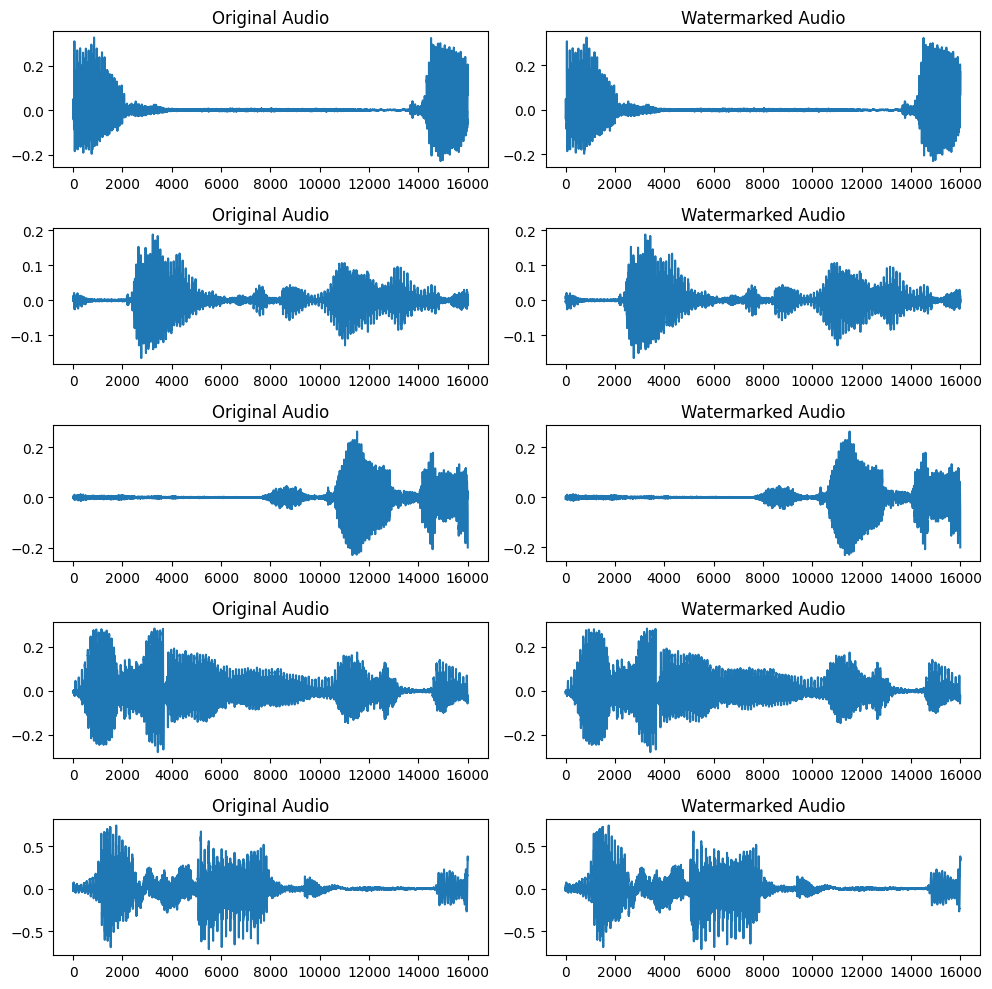

In [24]:
if __name__ == "__main__":
    # Define the data root and create the full dataset
    data_root = "data/200_speech_only"
    full_dataset = OneSecClipsDataset(root_dir=data_root, sample_rate=SAMPLE_RATE)
    
    # Split the dataset into training and validation (80/20 split)
    n = len(full_dataset)
    n_train = int(0.8 * n)
    n_val = n - n_train
    _, val_ds = random_split(full_dataset, [n_train, n_val])
    print(f"Validation set size: {len(val_ds)}")
    
    # Instantiate the generator and move it to the appropriate device
    generator = Generator().to(device)
    
    # Load the state dictionary and remove the "_orig_mod." prefix if it exists
    state_dict = torch.load("generator.pth", map_location=device)
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith("_orig_mod."):
            new_key = key[len("_orig_mod."):]
        else:
            new_key = key
        new_state_dict[new_key] = value
    generator.load_state_dict(new_state_dict)
    generator.eval()  # Set the model to evaluation mode
    
    # Evaluate the generator on the validation dataset using SI-SNR metric with a progress bar
    avg_si_snr = run_evaluation_generator_only(generator, val_ds, device, batch_size=16)
    print(f"Average SI-SNR on Validation Set: {avg_si_snr:.3f} dB")
    # Optionally, you can visualize some examples
    num_samples = 5
    indices = random.sample(range(len(val_ds)), num_samples)
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 2*num_samples))
    for i, idx in enumerate(indices):
        original = val_ds[idx].unsqueeze(0).to(device)  # (1, 1, T)
        with torch.no_grad():
            delta = generator(original)
            watermarked = original + delta

        # Plot original and watermarked audio
        axs[i, 0].plot(original.squeeze().cpu().numpy())
        axs[i, 0].set_title("Original Audio")
        axs[i, 1].plot(watermarked.squeeze().cpu().numpy())
        axs[i, 1].set_title("Watermarked Audio")
    plt.tight_layout()
    plt.show()

In [28]:
if __name__ == "__main__":
    # Define the data root paths
    data_root = "data/200_speech_only"  # Original data root
    custom_test_root = "data/test_5_hours"  # Your custom test set
    
    # Create the custom test dataset directly
    test_ds = OneSecClipsDataset(root_dir=custom_test_root, sample_rate=SAMPLE_RATE)
    print(f"Custom test set size: {len(test_ds)}")
    
    # Instantiate the generator and move it to the appropriate device
    generator = Generator().to(device)
    
    # Load the state dictionary and remove the "_orig_mod." prefix if it exists
    state_dict = torch.load("generator.pth", map_location=device)
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith("_orig_mod."):
            new_key = key[len("_orig_mod."):]
        else:
            new_key = key
        new_state_dict[new_key] = value
    generator.load_state_dict(new_state_dict)
    generator.eval()  # Set the model to evaluation mode
    
    # Evaluate the generator on your custom test dataset
    avg_si_snr = run_evaluation_generator_only(generator, test_ds, device, batch_size=16)
    print(f"Average SI-SNR on Custom Test Set: {avg_si_snr:.3f} dB")

Custom test set size: 19704


/tmp/ipykernel_8857/1234409758.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("generator.pth", map_location=device)


Average SI-SNR on Custom Test Set: 47.078 dB


### <span style="color: cyan;">Inference code</span>

In [15]:
# import os
# import torch
# import torchaudio
# import torch.nn.functional as F
# from tqdm import tqdm

# # ---------------------- Global Settings ---------------------- #
# SAMPLE_RATE = 16000     # Must match training
# AUDIO_LEN   = 16000     # 1 second = 16,000 samples at 16kHz
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------- Generator Loading ---------------------- #
def load_pretrained_generator(checkpoint_path="generator.pth"):
    """
    Instantiates the Generator architecture and loads the saved weights.
    (Assumes the Generator class is defined exactly as used during training.)
    """
    generator = Generator().to(device)
    
    # Load the state dict
    state_dict = torch.load(checkpoint_path, map_location=device)
    # If your state dict keys have a prefix (e.g. "_orig_mod."), remove it:
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith("_orig_mod."):
            new_key = key[len("_orig_mod."):]
        else:
            new_key = key
        new_state_dict[new_key] = value
    generator.load_state_dict(new_state_dict)
    generator.eval()
    print(f"Loaded generator weights from {checkpoint_path}")
    return generator

# ---------------------- SI-SNR Evaluation ---------------------- #
# def evaluate_si_snr_torch(original, reconstructed, eps=1e-8):
#     """
#     Computes the scale-invariant SNR (in dB) between original and reconstructed signals.
#     Assumes input shapes are (B, 1, T) or (B, T).
#     """
#     if original.dim() == 3:
#         original = original.squeeze(1)
#     if reconstructed.dim() == 3:
#         reconstructed = reconstructed.squeeze(1)
    
#     original_zm = original - original.mean(dim=1, keepdim=True)
#     recon_zm = reconstructed - reconstructed.mean(dim=1, keepdim=True)
    
#     dot = (original_zm * recon_zm).sum(dim=1, keepdim=True)
#     norm_sq = (original_zm ** 2).sum(dim=1, keepdim=True) + eps
#     alpha = dot / norm_sq
#     s_target = alpha * original_zm
#     e_noise = recon_zm - s_target
#     si_snr_val = 10 * torch.log10((s_target ** 2).sum(dim=1) / ((e_noise ** 2).sum(dim=1) + eps))
#     return si_snr_val

# ---------------------- Long Audio Watermarking ---------------------- #
def watermark_long_audio_file(
    generator,
    input_wav_path,
    output_wav_path,
    device,
    sample_rate=SAMPLE_RATE,
    chunk_size=16000,
    compute_si_snr=True
):
    """
    Processes an audio file of any length by splitting it into 1-second chunks,
    watermarks each chunk using the generator, and then concatenates the watermarked
    chunks into one full-length audio file which is then saved to output_wav_path.
    
    If the final chunk is shorter than 1 second, it is padded for processing and then trimmed.
    
    Returns:
        original_full (torch.Tensor): full original waveform (1, total_samples)
        watermarked_full (torch.Tensor): full watermarked waveform (1, total_samples)
        si_snr_value (float): SI-SNR value for the entire file if compute_si_snr is True; else None.
    """
    waveform, sr = torchaudio.load(input_wav_path) 
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True) 
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
        waveform = resampler(waveform)
    
    original_full = waveform.clone()
    num_samples = waveform.shape[1]
    watermarked_full = torch.zeros_like(waveform)
    
    generator.eval()
    start = 0
    while start < num_samples:
        end = start + chunk_size
        chunk = waveform[:, start:end] 
        current_chunk_len = chunk.shape[1]
        
        if current_chunk_len < chunk_size:
            pad_amt = chunk_size - current_chunk_len
            chunk = F.pad(chunk, (0, pad_amt))
        
        chunk_input = chunk.unsqueeze(0).to(device)
        with torch.no_grad():
            delta = generator(chunk_input)        
            chunk_wm = chunk_input + delta   
        
        chunk_wm = chunk_wm.squeeze(0).cpu() 
        if current_chunk_len < chunk_size:
            chunk_wm = chunk_wm[:, :current_chunk_len]
        
        watermarked_full[:, start:start+current_chunk_len] = chunk_wm
        start = end
    
    torchaudio.save(output_wav_path, watermarked_full, sample_rate=sample_rate)
    print(f"Watermarked audio saved to: {output_wav_path}")
    
    si_snr_value = None
    if compute_si_snr:
        orig_batched = original_full.unsqueeze(0)  #
        wm_batched = watermarked_full.unsqueeze(0)   
        si_snr_tensor = evaluate_si_snr_torch(orig_batched, wm_batched)
        si_snr_value = si_snr_tensor.item()
        print(f"SI-SNR for entire file: {si_snr_value:.2f} dB")
    
    return original_full, watermarked_full, si_snr_value

# ---------------------- Main Inference ---------------------- #
if __name__ == "__main__":
    generator_checkpoint = "generator.pth" 
    generator = load_pretrained_generator(generator_checkpoint)
    
   
    watermarked_dir = "watermarked"
    os.makedirs(watermarked_dir, exist_ok=True)

    test_files = [
        "data/raw_audios/en/2018/20180115-0900-PLENARY-7_en.ogg",
        "data/raw_audios/en/2018/20180117-0900-PLENARY-14_en.ogg",
        "data/raw_audios/en/2018/20180117-0900-PLENARY-13_en.ogg",
        "data/raw_audios/en/2018/20180117-0900-PLENARY-12_en.ogg",
        "data/raw_audios/en/2018/20180116-0900-PLENARY-12_en.ogg"
        # Add more files if needed
    ]
    
    for in_wav in test_files:
        base_name = os.path.basename(in_wav)
        name, ext = os.path.splitext(base_name)
        out_wav = os.path.join(watermarked_dir, f"{name}_watermarked{ext}")
        
        original, watermarked, si_snr_val = watermark_long_audio_file(
            generator=generator,
            input_wav_path=in_wav,
            output_wav_path=out_wav,
            device=device,
            sample_rate=SAMPLE_RATE,
            chunk_size=AUDIO_LEN,
            compute_si_snr=True
        )
        print(f"Processed {in_wav} -> {out_wav} with SI-SNR: {si_snr_val:.2f} dB")
    
    print(f"Done generating watermarked audio. Check the '{watermarked_dir}' directory.")


Loaded generator weights from generator.pth
Watermarked audio saved to: watermarked/20180115-0900-PLENARY-7_en_watermarked.ogg
SI-SNR for entire file: 50.73 dB
Processed data/raw_audios/en/2018/20180115-0900-PLENARY-7_en.ogg -> watermarked/20180115-0900-PLENARY-7_en_watermarked.ogg with SI-SNR: 50.73 dB


/tmp/ipykernel_8857/3710051929.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)


Watermarked audio saved to: watermarked/20180117-0900-PLENARY-14_en_watermarked.ogg
SI-SNR for entire file: 52.44 dB
Processed data/raw_audios/en/2018/20180117-0900-PLENARY-14_en.ogg -> watermarked/20180117-0900-PLENARY-14_en_watermarked.ogg with SI-SNR: 52.44 dB
Watermarked audio saved to: watermarked/20180117-0900-PLENARY-13_en_watermarked.ogg
SI-SNR for entire file: 44.70 dB
Processed data/raw_audios/en/2018/20180117-0900-PLENARY-13_en.ogg -> watermarked/20180117-0900-PLENARY-13_en_watermarked.ogg with SI-SNR: 44.70 dB
Watermarked audio saved to: watermarked/20180117-0900-PLENARY-12_en_watermarked.ogg
SI-SNR for entire file: 43.57 dB
Processed data/raw_audios/en/2018/20180117-0900-PLENARY-12_en.ogg -> watermarked/20180117-0900-PLENARY-12_en_watermarked.ogg with SI-SNR: 43.57 dB
Watermarked audio saved to: watermarked/20180116-0900-PLENARY-12_en_watermarked.ogg
SI-SNR for entire file: 46.87 dB
Processed data/raw_audios/en/2018/20180116-0900-PLENARY-12_en.ogg -> watermarked/20180116-0

In [16]:
import os
file_path = "data/raw_audio/en/2018/20180116-0900-PLENARY-12_en.ogg"
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    print(f"File exists: {file_path}")


File not found: data/raw_audio/en/2018/20180116-0900-PLENARY-12_en.ogg
